<a href="https://colab.research.google.com/github/uynzyy/Stock-Price-Prediction/blob/main/Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import thư viện**

In [7]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số tuyệt đối trung bình

**Đọc dữ liệu**

In [29]:
#tạo quyền truy cập với google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# đọc dữ liệu từ file csv
df = pd.read_csv('/content/drive/MyDrive/dataset//Dữ-liệu-Lịch-sử-TSLA-2.csv')

# Xóa hai dòng "KL" và "Thay đổi %" từ DataFrame dataSet
df = df.drop(columns=["KL", "% Thay đổi"])

# Hiển thị lại DataFrame sau khi xóa
print(df)

            Ngày  Lần cuối      Mở     Cao    Thấp
0     04/12/2023    235.58  235.75  239.37  233.29
1     01/12/2023    238.83  233.14  240.19  231.90
2     30/11/2023    240.08  245.14  245.22  236.91
3     29/11/2023    244.14  249.21  252.75  242.76
4     28/11/2023    246.72  236.68  247.00  234.01
...          ...       ...     ...     ...     ...
2745  08/01/2013      2.25    2.30    2.30    2.21
2746  07/01/2013      2.29    2.32    2.32    2.26
2747  04/01/2013      2.29    2.32    2.32    2.26
2748  03/01/2013      2.32    2.35    2.36    2.32
2749  02/01/2013      2.36    2.33    2.36    2.31

[2750 rows x 5 columns]


**Mô tả dữ liệu**

In [31]:
#định dạng cấu trúc thời gian
df["Ngày"] = pd.to_datetime(df.Ngày,format="%d/%m/%Y")

In [32]:
#kích thước dữ liệu
df.shape

(2750, 5)

In [33]:
#dữ liệu 5 dòng đầu
df.head()

,Ngày,Lần cuối,Mở,Cao,Thấp
0,2023-12-04,235.58,235.75,239.37,233.29
1,2023-12-01,238.83,233.14,240.19,231.90
2,2023-11-30,240.08,245.14,245.22,236.91
3,2023-11-29,244.14,249.21,252.75,242.76
4,2023-11-28,246.72,236.68,247.00,234.01


In [34]:
#xác định kiểu dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2750 entries, 0 to 2749
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Ngày      2750 non-null   datetime64[ns]
 1   Lần cuối  2750 non-null   float64       
 2   Mở        2750 non-null   float64       
 3   Cao       2750 non-null   float64       
 4   Thấp      2750 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 107.5 KB


In [35]:
#mô tả bộ dữ liệu
df.describe()

,Lần cuối,Mở,Cao,Thấp
count,2750.000000,2750.000000,2750.000000,2750.000000
mean,85.080753,85.104284,86.989487,83.070204
std,105.972422,106.059833,108.444065,103.425798
min,2.190000,2.210000,2.230000,2.140000
25%,14.790000,14.810000,15.040000,14.560000
50%,20.475000,20.430000,20.770000,20.055000
75%,181.852500,180.617500,185.197500,177.135000
max,409.970000,411.470000,414.500000,405.670000


**Tiền xử lý dữ liệu**

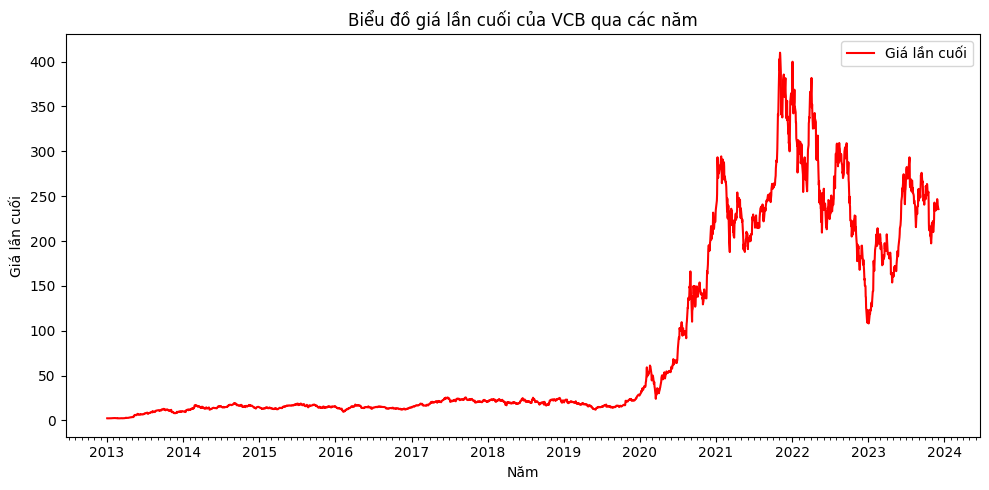

In [36]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi

# Chuyển đổi cột "Ngày" sang dạng datetime
df['Ngày'] = pd.to_datetime(df['Ngày'], format='%d/%m/%Y')

# Sắp xếp lại dữ liệu theo thứ tự thời gian
df = df.sort_values(by='Ngày')

# Chuyển đổi định dạng các cột giá thành số thực
df['Lần cuối'] = df['Lần cuối'].apply(str).str.replace(',', '').astype(float)
df['Mở'] = df['Mở'].apply(str).str.replace(',', '').astype(float)
df['Cao'] = df['Cao'].apply(str).str.replace(',', '').astype(float)
df['Thấp'] = df['Thấp'].apply(str).str.replace(',', '').astype(float)

# Lấy thông tin năm từ cột "Ngày"
df['Năm'] = df['Ngày'].dt.year

# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df['Ngày'], df['Lần cuối'], label='Giá lần cuối', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá lần cuối')
plt.title('Biểu đồ giá lần cuối của VCB qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout()
plt.show()

In [37]:
df1 = pd.DataFrame(df,columns=['Ngày','Lần cuối'])
df1.index = df1.Ngày
df1.drop('Ngày',axis=1,inplace=True)
df1

,Lần cuối
Ngày,
2013-01-02,2.36
2013-01-03,2.32
2013-01-04,2.29
2013-01-07,2.29
2013-01-08,2.25
...,...
2023-11-28,246.72
2023-11-29,244.14
2023-11-30,240.08


In [38]:
#chia tập dữ liệu
data = df1.values
train_data = data[:1500]
test_data = data[1500:]

In [39]:
data

array([[  2.36],
       [  2.32],
       [  2.29],
       ...,
       [240.08],
       [238.83],
       [235.58]])

In [40]:
#chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0,1))
sc_train = sc.fit_transform(data)

In [41]:
#tạo vòng lặp các giá trị
x_train,y_train=[],[]
for i in range(50,len(train_data)):
  x_train.append(sc_train[i-50:i,0]) #lấy 50 giá đóng cửa liên tục
  y_train.append(sc_train[i,0]) #lấy ra giá đóng cửa ngày hôm sau

In [42]:
x_train

[array([4.16891461e-04, 3.18799353e-04, 2.45230271e-04, 2.45230271e-04,
        1.47138163e-04, 1.22615136e-04, 1.22615136e-04, 0.00000000e+00,
        7.35690814e-05, 1.71661190e-04, 1.96184217e-04, 2.45230271e-04,
        2.69753298e-04, 3.92368434e-04, 5.14983570e-04, 6.86644759e-04,
        6.86644759e-04, 8.58305949e-04, 8.33782922e-04, 7.60213841e-04,
        7.60213841e-04, 8.82828976e-04, 8.09259895e-04, 8.58305949e-04,
        1.02996714e-03, 1.07901319e-03, 1.05449017e-03, 9.07352004e-04,
        8.33782922e-04, 9.07352004e-04, 8.82828976e-04, 6.86644759e-04,
        1.05449017e-03, 9.31875031e-04, 3.67845407e-04, 5.39506597e-04,
        2.45230271e-04, 2.69753298e-04, 3.67845407e-04, 3.18799353e-04,
        2.94276325e-04, 4.41414488e-04, 6.13075678e-04, 7.84736868e-04,
        8.82828976e-04, 9.07352004e-04, 1.02996714e-03, 1.02996714e-03,
        1.00544411e-03, 6.62121732e-04]),
 array([3.18799353e-04, 2.45230271e-04, 2.45230271e-04, 1.47138163e-04,
        1.22615136e-04

In [43]:
y_train

[0.00039236843395948785,
 0.00036784540683701926,
 0.00036784540683701926,
 0.0005149835695718282,
 0.0005149835695718282,
 0.0006130756780616999,
 0.000760213840796508,
 0.0008092598950414443,
 0.0008583059492863797,
 0.0008337829221639111,
 0.001814704007062632,
 0.001888273088430036,
 0.0013487664917357402,
 0.0014959046544705474,
 0.0013978125459806756,
 0.0014713816273480796,
 0.0012506743832458684,
 0.0014713816273480796,
 0.0017656579528176966,
 0.0017901809799401635,
 0.0017166118985727603,
 0.0020844573054097796,
 0.002059934278287311,
 0.0023051645495119916,
 0.0024523027122467997,
 0.0028446711462062884,
 0.002967286281818627,
 0.002869194173328756,
 0.0031389474716759045,
 0.0029918093089410965,
 0.0036048849870027964,
 0.0034577468242679883,
 0.003335131688655648,
 0.003482269851390456,
 0.003555838932757859,
 0.004365098827799304,
 0.0037029770954926673,
 0.0037520231497376044,
 0.005983618617882191,
 0.007185246946883123,
 0.008975427926823286,
 0.008239737113149247,
 0.

In [45]:
#xếp dữ liệu thành 1 mảng 2 chiều
x_train = np.array(x_train)
y_train = np.array(y_train)

#xếp lại dữ liệu thành mảng 1 chiều
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))

**Xây dựng và huấn luyện mô hình**

In [47]:
#xây dựng mô hình
model = Sequential() #tạo lớp mạng cho dữ liệu đầu vào
#2 lớp LSTM
model.add(LSTM(units=128,input_shape=(x_train.shape[1],1),return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5)) #loại bỏ 1 số đơn vị tránh học tủ (overfitting)
model.add(Dense(1)) #output đầu ra 1 chiều
#đo sai số tuyệt đối trung bình có sử dụng trình tối ưu hóa adam
model.compile(loss='mean_absolute_error',optimizer='adam')

In [48]:
#huấn luyện mô hình
save_model = "/content/drive/MyDrive/dataset/save_model.hdf5"
best_model = ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True,mode='auto')
model.fit(x_train,y_train,epochs=100,batch_size=50,verbose=2,callbacks=[best_model])

Epoch 1/100

Epoch 1: loss improved from inf to 0.01106, saving model to /content/drive/MyDrive/dataset/save_model.hdf5
29/29 - 8s - loss: 0.0111 - 8s/epoch - 281ms/step
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: loss improved from 0.01106 to 0.00523, saving model to /content/drive/MyDrive/dataset/save_model.hdf5
29/29 - 3s - loss: 0.0052 - 3s/epoch - 89ms/step
Epoch 3/100

Epoch 3: loss improved from 0.00523 to 0.00434, saving model to /content/drive/MyDrive/dataset/save_model.hdf5
29/29 - 2s - loss: 0.0043 - 2s/epoch - 73ms/step
Epoch 4/100

Epoch 4: loss improved from 0.00434 to 0.00380, saving model to /content/drive/MyDrive/dataset/save_model.hdf5
29/29 - 2s - loss: 0.0038 - 2s/epoch - 74ms/step
Epoch 5/100

Epoch 5: loss did not improve from 0.00380
29/29 - 2s - loss: 0.0040 - 2s/epoch - 73ms/step
Epoch 6/100

Epoch 6: loss improved from 0.00380 to 0.00312, saving model to /content/drive/MyDrive/dataset/save_model.hdf5
29/29 - 2s - loss: 0.0031 - 2s/epoch - 72ms/step
Epoch 7/100

Epoch 7: loss improved from 0.00312 to 0.00290, saving model to /content/drive/MyDrive/dataset/save_model.hdf5
29/29 - 4s - loss: 0.0029 - 4s/epoch - 130ms/step
Epoch 8/100

Epoch 8: loss did not improv

In [49]:
#dữ liệu train
y_train = sc.inverse_transform(y_train) #giá thực
final_model = load_model("/content/drive/MyDrive/dataset/save_model.hdf5")
y_train_predict = final_model.predict(x_train) #dự đoán giá đóng cửa trên tập đã train
y_train_predict = sc.inverse_transform(y_train_predict) #giá dự đoán

46/46 [==============================] - 2s 22ms/step


**Tái sử dụng mô hình**

In [50]:
#xử lý dữ liệu test
test = df1[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(50,test.shape[0]):
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[1500:] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

40/40 [==============================] - 1s 19ms/step


**Độ chính xác của mô hình**

<ipython-input-51-4f5867c1eb90>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
<ipython-input-51-4f5867c1eb90>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu


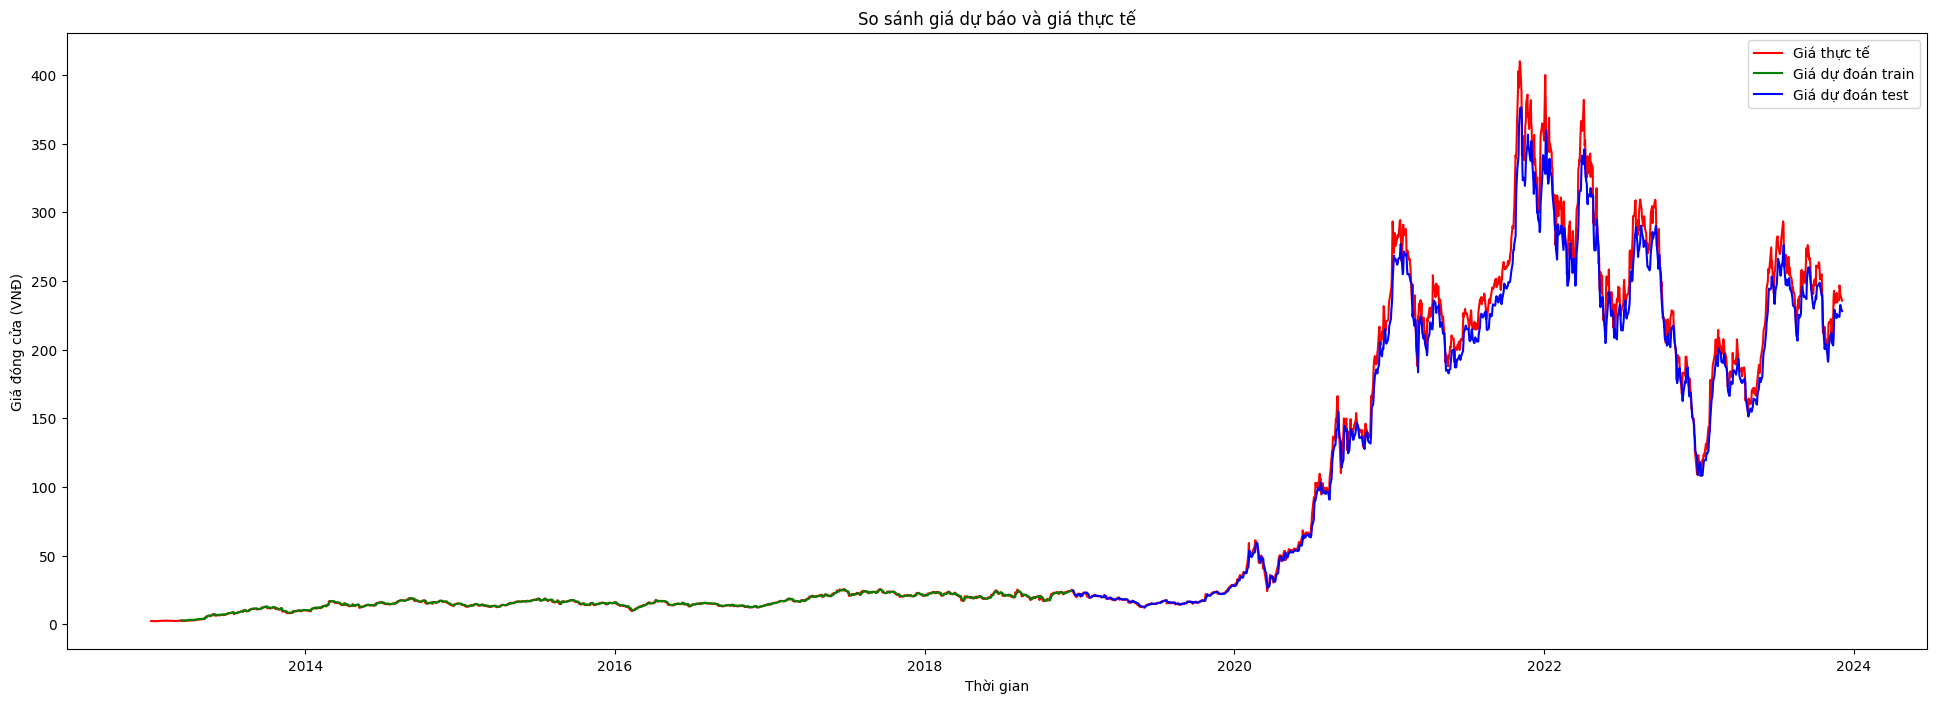

In [51]:
#lập biểu đồ so sánh
train_data1 = df1[50:1500]
test_data1 = df1[1500:]

plt.figure(figsize=(24,8))
plt.plot(df1,label='Giá thực tế',color='red') #đường giá thực
train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
plt.plot(train_data1['Dự đoán'],label='Giá dự đoán train',color='green') #đường giá dự báo train
test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu
plt.plot(test_data1['Dự đoán'],label='Giá dự đoán test',color='blue') #đường giá dự báo test
plt.title('So sánh giá dự báo và giá thực tế') #đặt tên biểu đồ
plt.xlabel('Thời gian') #đặt tên hàm x
plt.ylabel('Giá đóng cửa (VNĐ)') #đặt tên hàm y
plt.legend() #chú thích
plt.show()

In [52]:
#r2
print('Độ phù hợp tập train:',r2_score(y_train,y_train_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):',mean_absolute_error(y_train,y_train_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập train:',mean_absolute_percentage_error(y_train,y_train_predict))

Độ phù hợp tập train: 0.9871965414337929
Sai số tuyệt đối trung bình trên tập train (VNĐ): 0.39343110126626907
Phần trăm sai số tuyệt đối trung bình tập train: 0.027904496391124245


In [53]:
train_data1

,Lần cuối,Dự đoán
Ngày,,
2013-03-15,2.35,2.935487
2013-03-18,2.34,2.830364
2013-03-19,2.34,2.760586
2013-03-20,2.40,2.735840
2013-03-21,2.40,2.764459
...,...,...
2018-12-10,24.34,23.943441
2018-12-11,24.45,24.048363
2018-12-12,24.44,24.205084


In [54]:
#r2
print('Độ phù hợp tập test:',r2_score(y_test,y_test_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):',mean_absolute_error(y_test,y_test_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập test:',mean_absolute_percentage_error(y_test,y_test_predict))

Độ phù hợp tập test: 0.9843637800035161
Sai số tuyệt đối trung bình trên tập test (VNĐ): 9.459855660614013
Phần trăm sai số tuyệt đối trung bình tập test: 0.04949510073015874


In [55]:
test_data1

,Lần cuối,Dự đoán
Ngày,,
2018-12-17,23.23,24.561829
2018-12-18,22.47,23.857176
2018-12-19,22.20,22.962978
2018-12-20,21.03,22.328409
2018-12-21,21.32,21.546785
...,...,...
2023-11-28,246.72,223.895798
2023-11-29,244.14,229.841431
2023-11-30,240.08,232.533722


**Thử dự đoán giá tương lai và so sánh với giá ngày cuối**

1/1 [==============================] - 0s 36ms/step


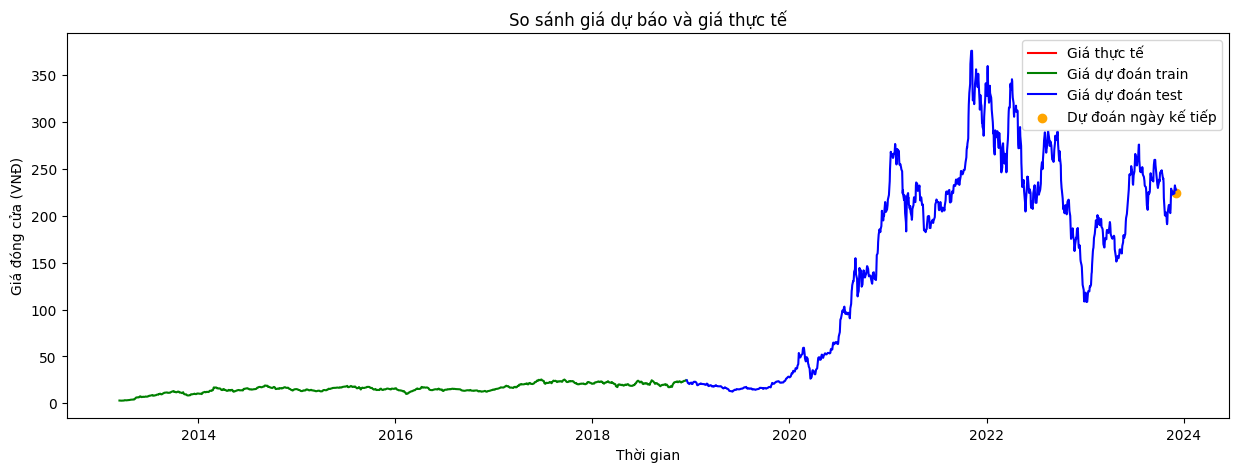

In [56]:
# Lấy ngày kế tiếp sau ngày cuối cùng trong tập dữ liệu để dự đoán
next_date = df['Ngày'].iloc[-1] + pd.Timedelta(days=1)

# Chuyển đổi ngày kế tiếp sang dạng datetime
next_date = pd.to_datetime(next_date)

# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
next_closing_price = np.array([df['Lần cuối'].iloc[-1]])  # Lấy giá trị đóng cửa của ngày cuối cùng

# Chuẩn hóa giá trị của ngày cuối cùng
next_closing_price_normalized = sc.transform(next_closing_price.reshape(-1, 1))  # Chuyển thành mảng 2D

# Tạo dự đoán cho ngày kế tiếp bằng mô hình đã huấn luyện
x_next = np.array([sc_train[-50:, 0]])  # Lấy 50 giá đóng cửa gần nhất
x_next = np.reshape(x_next, (x_next.shape[0], x_next.shape[1], 1))
y_next_predict = final_model.predict(x_next)
y_next_predict = sc.inverse_transform(y_next_predict)

# Thêm dữ liệu dự đoán của ngày kế tiếp vào DataFrame
df_next = pd.DataFrame({'Ngày': [next_date], 'Lần cuối': [y_next_predict[0][0]]})
df1 = pd.concat([df1, df_next])

# Vẽ biểu đồ mới với dự đoán cho ngày kế tiếp
plt.figure(figsize=(15, 5))
plt.plot(df1['Ngày'], df1['Lần cuối'], label='Giá thực tế', color='red')
plt.plot(train_data1.index, train_data1['Dự đoán'], label='Giá dự đoán train', color='green')
plt.plot(test_data1.index, test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.scatter([next_date], [y_next_predict[0][0]], color='orange', label='Dự đoán ngày kế tiếp')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.title('So sánh giá dự báo và giá thực tế')
plt.legend()
plt.show()


In [57]:
# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
actual_closing_price = df['Lần cuối'].iloc[-1]

# Tạo DataFrame so sánh giá dự đoán với giá ngày cuối trong tập dữ liệu
comparison_df = pd.DataFrame({'Ngày': [next_date], 'Giá dự đoán': [y_next_predict[0][0]], 'Giá ngày trước': [actual_closing_price]})

# In ra bảng so sánh
print(comparison_df)

        Ngày  Giá dự đoán  Giá ngày trước
0 2023-12-05   224.818756          235.58
